# Phase 2: Implementing DeepCluster

---

## 1. Extract the data in an NWB file

### Import required modules

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
import os
import re
import pickle

import torch
import torch.nn as nn
from torchinfo import summary

from torch.utils.data import DataLoader
from collections import Counter

from pycave.bayes import GaussianMixture
import warnings
warnings.simplefilter("ignore")

%matplotlib widget

In [2]:
import spikeinterface.full as si
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [3]:
print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.98.2


In [4]:
import preprocessing
import process_peaks
import dataset
import model
import deepcluster

### Read the NWB file

In [5]:
base_folder = Path(".")
nwb_file = "sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb"

In [6]:
recording_nwb = si.read_nwb(nwb_file, electrical_series_name='ElectricalSeriesAp')
recording_nwb

NwbRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 125,189,472 samples 
                       4,172.98s (1.16 hours) - int16 dtype - 89.54 GiB
  file_path: /pscratch/sd/v/vlavan/sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb

In [7]:
recording_nwb.annotate(is_filtered=False)

### Preprocess the recording

In [8]:
recording_f = si.bandpass_filter(recording_nwb, freq_min=300, freq_max=6000)
recording_f

BandpassFilterRecording: 384 channels - 30.0kHz - 1 segments - 125,189,472 samples 
                         4,172.98s (1.16 hours) - int16 dtype - 89.54 GiB

In [9]:
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
recording_cmr

CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 125,189,472 samples 
                          4,172.98s (1.16 hours) - int16 dtype - 89.54 GiB

### Extract channels and spikes information

In [10]:
recording_slice = preprocessing.channel_slice_electricalseriesap(recording_cmr)
recording_slice

ChannelSliceRecording: 384 channels - 30.0kHz - 1 segments - 125,189,472 samples 
                       4,172.98s (1.16 hours) - int16 dtype - 89.54 GiB

In [11]:
channels_table = preprocessing.extract_channels(recording_slice)
display(channels_table)

,channel_id,channel_loc_x,channel_loc_y
0,AP0,16.0,0.0
1,AP1,48.0,0.0
2,AP2,0.0,20.0
3,AP3,32.0,20.0
4,AP4,16.0,40.0
...,...,...,...
379,AP379,32.0,3780.0
380,AP380,16.0,3800.0
381,AP381,48.0,3800.0
382,AP382,0.0,3820.0


In [12]:
channels_table['channel_loc_x'].unique()

array([16., 48.,  0., 32.])

In [13]:
sorting_nwb = si.read_nwb_sorting(file_path=nwb_file, electrical_series_name='ElectricalSeriesAp')
sorting_nwb

NwbSortingExtractor: 423 units - 1 segments - 30.0kHz
  file_path: /pscratch/sd/v/vlavan/sub-CSHL049_ses-c99d53e6-c317-4c53-99ba-070b26673ac4_behavior+ecephys+image.nwb

In [14]:
waveform_folder = 'waveform'

job_kwargs = dict(n_jobs=10, chunk_duration="1s", progress_bar=True)

In [15]:
if (base_folder / waveform_folder).is_dir():
    waveform_nwb = si.load_waveforms(base_folder / waveform_folder, with_recording=False)
else:
    waveform_nwb = si.extract_waveforms(
        recording_slice,
        sorting_nwb,
        waveform_folder,
        ms_before=1.5,
        ms_after=2.,
        max_spikes_per_unit=None,
        overwrite=True,
        **job_kwargs
    )

In [16]:
waveform_nwb

WaveformExtractor: 384 channels - 423 units - 1 segments
  before:45 after:60 n_per_units:None

In [17]:
spikes_table = preprocessing.extract_spikes(sorting_nwb, waveform_nwb)
display(spikes_table)

,unit_id,peak_frame,peak_channel
0,0,471,341
1,1,511,361
2,2,606,354
3,1,680,361
4,3,715,325
...,...,...,...
4604408,372,125188815,21
4604409,41,125188837,155
4604410,102,125188911,325
4604411,316,125188967,326


In [18]:
peaks_folder = 'peaks'

job_kwargs = dict(chunk_duration='1s', n_jobs=8, progress_bar=True)

In [19]:
if (base_folder / peaks_folder).is_dir():
    peaks = process_peaks.load_peaks(base_folder / peaks_folder)
else:
    peaks = detect_peaks(
        recording_slice,
        method='locally_exclusive',
        peak_sign='neg',
        detect_threshold=6,
        **job_kwargs
    )
    
    process_peaks.save_peaks(peaks, base_folder / peaks_folder)

In [20]:
peaks_table = process_peaks.extract_peaks(recording_slice, peaks)
display(peaks_table)

,peak_frame,peak_channel
0,92,326
1,134,186
2,147,348
3,177,337
4,269,330
...,...,...
4062000,125189400,155
4062001,125189402,89
4062002,125189402,269
4062003,125189408,287


---

## 2. Match peaks to spikes

In [21]:
peaks_matched_table_file = os.path.join(peaks_folder, "peaks_matched_table.pkl")

if os.path.exists(peaks_matched_table_file):
    peaks_matched_table = pd.read_pickle(peaks_matched_table_file)
else:
    peaks_matched_table = process_peaks.match_peaks(peaks_table, spikes_table, channels_table)
    peaks_matched_table.to_pickle(peaks_matched_table_file)
    
display(peaks_matched_table)

,unit_id,peak_frame,peak_channel
0,-1,92,326
1,-1,134,186
2,-1,147,348
3,-1,177,337
4,-1,269,330
...,...,...,...
4062000,-1,125189400,155
4062001,-1,125189402,89
4062002,-1,125189402,269
4062003,-1,125189408,287


## 3. Create a dataset from matched peaks

In [22]:
peaks_dataset_folder = os.path.join(peaks_folder, 'peaks_dataset')

if not os.path.exists(peaks_dataset_folder):
    os.mkdir(peaks_dataset_folder)

In [23]:
unit_counts = peaks_matched_table['unit_id'].value_counts()
filtered_units = unit_counts[(unit_counts >= 3000) & (unit_counts <= 4000)]
selected_units = filtered_units.sample(n=3, random_state=1).index.to_list()

print(selected_units)

[305, 116, 310]


In [24]:
peaks_dataset = dataset.UnsupervisedDataset(peaks_dataset_folder, selected_units, shuffle=True, seed=0)
print('Dataset:', len(peaks_dataset))

Dataset: 10233


In [25]:
classes = peaks_dataset.get_labels()
print(Counter(classes))

Counter({310: 3797, 116: 3336, 305: 3100})


In [26]:
peaks_dataloader = DataLoader(
        peaks_dataset,
        batch_size=64
)

---

## 4. Implementing DeepCluster

In [45]:
import importlib

preprocessing = importlib.reload(preprocessing)
process_peaks = importlib.reload(process_peaks)
dataset = importlib.reload(dataset)
model = importlib.reload(model)
deepcluster = importlib.reload(deepcluster)

In [27]:
!nvidia-smi

Thu Nov 23 00:26:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   33C    P0    35W / 250W |   3804MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
num_classes=3
deepcluster_model = model.DeepCluster(num_classes)
gmm = GaussianMixture(num_classes, covariance_type="full", init_strategy='kmeans', trainer_params=dict(gpus=[0]))

In [29]:
device=torch.device("cuda:0")
device_ids=[0]

In [30]:
deepcluster_kwargs = dict(
    device=torch.device("cuda:0"), 
    device_ids=[0], 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=torch.optim.Adam(deepcluster_model.parameters(), lr=0.0001),
    sampling_frequency = 30000,
    epochs=200
)

Epoch 1
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 44.10it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Classification
- Epoch: [1][0/160]	Time: 0.224 (0.224)	Data: 0.031 (0.031)	Loss: 1.3197 (1.3197)
- Epoch: [1][50/160]	Time: 0.025 (0.035)	Data: 0.017 (0.022)	Loss: 0.5264 (0.8965)
- Epoch: [1][100/160]	Time: 0.022 (0.029)	Data: 0.014 (0.019)	Loss: 0.5301 (0.6835)
- Epoch: [1][150/160]	Time: 0.030 (0.027)	Data: 0.022 (0.018)	Loss: 0.2964 (0.5823)


Epoch 2
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 52.49it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3349   256    57
1    41   167  2809
2   422  2856   226 

- Agreement Scores:
          0         1         2
0  0.799857  0.038118  0.008452
1  0.005998  0.027172  0.842784
2  0.060895  0.726348  0.035362 

- Cluster Change: 1169
- Least Change: 1169
- Convergence Epochs: [0/5]
- Time: 73.4916 seconds

Classification
- Epoch: [2][0/160]	Time: 0.049 (0.049)	Data: 0.032 (0.032)	Loss: 2.5687 (2.5687)
- Epoch: [2][50/160]	Time: 0.029 (0.032)	Data: 0.020 (0.020)	Loss: 0.4587 (0.7805)
- Epoch: [2][100/160]	Time: 0.033 (0.032)	Data: 0.024 (0.021)	Loss: 0.2658 (0.5301)
- Epoch: [2][150/160]	Time: 0.024 (0.032)	Data: 0.015 (0.021)	Loss: 0.1736 (0.4180)


Epoch 3
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 41.05it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3725    32    57
1    97    86  3099
2     6  3059    33 

- Agreement Scores:
          0         1         2
0  0.936636  0.004571  0.008173
1  0.013776  0.013475  0.920131
2  0.000862  0.944719  0.005269 

- Cluster Change: 311
- Least Change: 311
- Convergence Epochs: [0/5]
- Time: 4.3042 seconds

Classification
- Epoch: [3][0/160]	Time: 0.035 (0.035)	Data: 0.021 (0.021)	Loss: 3.2498 (3.2498)
- Epoch: [3][50/160]	Time: 0.031 (0.033)	Data: 0.023 (0.020)	Loss: 0.2503 (0.6167)
- Epoch: [3][100/160]	Time: 0.027 (0.030)	Data: 0.015 (0.018)	Loss: 0.1184 (0.3891)
- Epoch: [3][150/160]	Time: 0.028 (0.029)	Data: 0.015 (0.017)	Loss: 0.0697 (0.2958)


Epoch 4
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 56.46it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    13     8  3802
1    17  3142    11
2  3145    21    22 

- Agreement Scores:
          0         1         2
0  0.001852  0.001137  0.968416
1  0.002679  0.971252  0.001561
2  0.977923  0.003304  0.003127 

- Cluster Change: 92
- Least Change: 92
- Convergence Epochs: [0/5]
- Time: 3.5365 seconds

Classification
- Epoch: [4][0/160]	Time: 0.049 (0.049)	Data: 0.030 (0.030)	Loss: 3.8483 (3.8483)
- Epoch: [4][50/160]	Time: 0.034 (0.036)	Data: 0.022 (0.025)	Loss: 0.2314 (0.9126)
- Epoch: [4][100/160]	Time: 0.033 (0.036)	Data: 0.024 (0.024)	Loss: 0.1611 (0.5477)
- Epoch: [4][150/160]	Time: 0.037 (0.035)	Data: 0.025 (0.024)	Loss: 0.0576 (0.4061)


Epoch 5
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 44.14it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0   105    22  3047
1     5  3172     4
2  3778    22    29 

- Agreement Scores:
          0         1         2
0  0.014998  0.003450  0.950999
1  0.000703  0.978710  0.000639
2  0.938867  0.003111  0.004192 

- Cluster Change: 187
- Least Change: 92
- Convergence Epochs: [0/5]
- Time: 3.9902 seconds

Classification
- Epoch: [5][0/160]	Time: 0.039 (0.039)	Data: 0.027 (0.027)	Loss: 2.6678 (2.6678)
- Epoch: [5][50/160]	Time: 0.034 (0.037)	Data: 0.021 (0.025)	Loss: 0.2668 (0.7694)
- Epoch: [5][100/160]	Time: 0.027 (0.033)	Data: 0.015 (0.021)	Loss: 0.0941 (0.4749)
- Epoch: [5][150/160]	Time: 0.028 (0.031)	Data: 0.015 (0.019)	Loss: 0.0894 (0.3572)


Epoch 6
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 59.06it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3782    51    52
1     4     8  3193
2    31  3033    15 

- Agreement Scores:
          0         1         2
0  0.942202  0.007316  0.007264
1  0.000565  0.001269  0.964653
2  0.004486  0.967773  0.002366 

- Cluster Change: 161
- Least Change: 92
- Convergence Epochs: [0/5]
- Time: 4.2537 seconds

Classification
- Epoch: [6][0/160]	Time: 0.034 (0.034)	Data: 0.024 (0.024)	Loss: 5.6348 (5.6348)
- Epoch: [6][50/160]	Time: 0.038 (0.035)	Data: 0.026 (0.023)	Loss: 0.2444 (0.8776)
- Epoch: [6][100/160]	Time: 0.027 (0.033)	Data: 0.015 (0.022)	Loss: 0.0546 (0.5309)
- Epoch: [6][150/160]	Time: 0.039 (0.033)	Data: 0.026 (0.022)	Loss: 0.0541 (0.3940)


Epoch 7
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 56.75it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3788    27    17
1    13  3061    18
2     9    14  3236 

- Agreement Scores:
          0         1         2
0  0.966820  0.003892  0.002382
1  0.001879  0.978268  0.002829
2  0.001265  0.002200  0.970606 

- Cluster Change: 98
- Least Change: 92
- Convergence Epochs: [0/5]
- Time: 4.0227 seconds

Classification
- Epoch: [7][0/160]	Time: 0.046 (0.046)	Data: 0.031 (0.031)	Loss: 0.0330 (0.0330)
- Epoch: [7][50/160]	Time: 0.031 (0.035)	Data: 0.022 (0.026)	Loss: 0.0503 (0.0662)
- Epoch: [7][100/160]	Time: 0.024 (0.031)	Data: 0.015 (0.022)	Loss: 0.0275 (0.0623)
- Epoch: [7][150/160]	Time: 0.025 (0.030)	Data: 0.015 (0.020)	Loss: 0.0360 (0.0618)


Epoch 8
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 57.40it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     8  3774    23
1  3091     1    10
2     3     4  3266 

- Agreement Scores:
          0         1         2
0  0.001154  0.971679  0.003223
1  0.994210  0.000145  0.001561
2  0.000470  0.000563  0.977259 

- Cluster Change: 49
- Least Change: 49
- Convergence Epochs: [1/5]
- Time: 4.3628 seconds

Classification
- Epoch: [8][0/160]	Time: 0.037 (0.037)	Data: 0.026 (0.026)	Loss: 5.0999 (5.0999)
- Epoch: [8][50/160]	Time: 0.035 (0.036)	Data: 0.022 (0.025)	Loss: 0.3504 (1.0454)
- Epoch: [8][100/160]	Time: 0.024 (0.032)	Data: 0.015 (0.021)	Loss: 0.0567 (0.6384)
- Epoch: [8][150/160]	Time: 0.028 (0.029)	Data: 0.015 (0.019)	Loss: 0.0518 (0.4698)


Epoch 9
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 58.55it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
     0     1     2
0    2  3092     3
1  616   110  3057
2  962  2335     5 

- Agreement Scores:
          0         1         2
0  0.000427  0.555815  0.000485
1  0.128682  0.011878  0.794026
2  0.244039  0.357197  0.000781 

- Cluster Change: 4028
- Least Change: 49
- Convergence Epochs: [1/5]
- Time: 3.9670 seconds

Classification
- Epoch: [9][0/160]	Time: 0.041 (0.041)	Data: 0.026 (0.026)	Loss: 10.0717 (10.0717)
- Epoch: [9][50/160]	Time: 0.031 (0.035)	Data: 0.022 (0.025)	Loss: 0.7985 (1.6522)
- Epoch: [9][100/160]	Time: 0.027 (0.031)	Data: 0.015 (0.021)	Loss: 0.7391 (1.1607)
- Epoch: [9][150/160]	Time: 0.023 (0.030)	Data: 0.015 (0.019)	Loss: 0.3958 (0.9400)


Epoch 10
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 60.32it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0   615     7   962
1    79  3441  2020
2  3043    12     3 

- Agreement Scores:
          0         1         2
0  0.129583  0.001388  0.265599
1  0.008541  0.617109  0.309247
2  0.796180  0.001835  0.000493 

- Cluster Change: 2736
- Least Change: 49
- Convergence Epochs: [1/5]
- Time: 3.5681 seconds

Classification
- Epoch: [10][0/160]	Time: 0.042 (0.042)	Data: 0.028 (0.028)	Loss: 3.1977 (3.1977)
- Epoch: [10][50/160]	Time: 0.035 (0.038)	Data: 0.025 (0.026)	Loss: 0.3488 (0.8528)
- Epoch: [10][100/160]	Time: 0.034 (0.035)	Data: 0.025 (0.024)	Loss: 0.1111 (0.5346)
- Epoch: [10][150/160]	Time: 0.028 (0.035)	Data: 0.019 (0.023)	Loss: 0.1163 (0.3961)


Epoch 11
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 53.59it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3716     4     6
1     7  3325   130
2    12    32  2943 

- Agreement Scores:
          0         1         2
0  0.967456  0.000561  0.000875
1  0.000967  0.950543  0.020246
2  0.001773  0.005058  0.936367 

- Cluster Change: 191
- Least Change: 49
- Convergence Epochs: [1/5]
- Time: 4.1975 seconds

Classification
- Epoch: [11][0/160]	Time: 0.032 (0.032)	Data: 0.022 (0.022)	Loss: 0.0958 (0.0958)
- Epoch: [11][50/160]	Time: 0.034 (0.031)	Data: 0.019 (0.019)	Loss: 0.0627 (0.0611)
- Epoch: [11][100/160]	Time: 0.034 (0.031)	Data: 0.024 (0.020)	Loss: 0.0475 (0.0511)
- Epoch: [11][150/160]	Time: 0.025 (0.031)	Data: 0.016 (0.021)	Loss: 0.0208 (0.0472)


Epoch 12
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 49.33it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     3  3723     3
1    27     2  3332
2  3063     4     3 

- Agreement Scores:
          0         1         2
0  0.000435  0.968774  0.000421
1  0.004189  0.000280  0.989605
2  0.976099  0.000582  0.000467 

- Cluster Change: 42
- Least Change: 42
- Convergence Epochs: [2/5]
- Time: 4.0913 seconds

Classification
- Epoch: [12][0/160]	Time: 0.037 (0.037)	Data: 0.024 (0.024)	Loss: 9.4185 (9.4185)
- Epoch: [12][50/160]	Time: 0.035 (0.033)	Data: 0.022 (0.022)	Loss: 0.7156 (1.6958)
- Epoch: [12][100/160]	Time: 0.033 (0.032)	Data: 0.024 (0.021)	Loss: 0.2305 (1.0805)
- Epoch: [12][150/160]	Time: 0.027 (0.033)	Data: 0.019 (0.022)	Loss: 0.1048 (0.7750)


Epoch 13
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 47.12it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    14     9  3076
1     7  3717     5
2  3293     6    41 

- Agreement Scores:
          0         1         2
0  0.002184  0.001306  0.970041
1  0.000988  0.964953  0.000723
2  0.980935  0.000843  0.006374 

- Cluster Change: 82
- Least Change: 42
- Convergence Epochs: [2/5]
- Time: 4.0954 seconds

Classification
- Epoch: [13][0/160]	Time: 0.037 (0.037)	Data: 0.023 (0.023)	Loss: 3.8360 (3.8360)
- Epoch: [13][50/160]	Time: 0.035 (0.036)	Data: 0.022 (0.023)	Loss: 0.2046 (0.7258)
- Epoch: [13][100/160]	Time: 0.027 (0.032)	Data: 0.016 (0.020)	Loss: 0.0962 (0.4453)
- Epoch: [13][150/160]	Time: 0.024 (0.030)	Data: 0.014 (0.018)	Loss: 0.0908 (0.3275)


Epoch 14
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 47.22it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     4  3277    31
1  3728     2     6
2     4     3  3107 

- Agreement Scores:
          0         1         2
0  0.000564  0.987941  0.004809
1  0.969823  0.000283  0.000864
2  0.000578  0.000468  0.973066 

- Cluster Change: 50
- Least Change: 42
- Convergence Epochs: [2/5]
- Time: 4.0694 seconds

Classification
- Epoch: [14][0/160]	Time: 0.037 (0.037)	Data: 0.023 (0.023)	Loss: 4.2526 (4.2526)
- Epoch: [14][50/160]	Time: 0.033 (0.036)	Data: 0.023 (0.023)	Loss: 0.2971 (0.9641)
- Epoch: [14][100/160]	Time: 0.026 (0.032)	Data: 0.014 (0.020)	Loss: 0.0803 (0.5678)
- Epoch: [14][150/160]	Time: 0.029 (0.030)	Data: 0.016 (0.018)	Loss: 0.0127 (0.4066)


Epoch 15
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 62.40it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    25  3713     3
1    17     1  3266
2  3146     3     6 

- Agreement Scores:
          0         1         2
0  0.003592  0.968188  0.000425
1  0.002630  0.000142  0.993007
2  0.977930  0.000433  0.000933 

- Cluster Change: 55
- Least Change: 42
- Convergence Epochs: [2/5]
- Time: 5.8637 seconds

Classification
- Epoch: [15][0/160]	Time: 0.043 (0.043)	Data: 0.019 (0.019)	Loss: 8.2442 (8.2442)
- Epoch: [15][50/160]	Time: 0.031 (0.031)	Data: 0.019 (0.019)	Loss: 0.4520 (1.4231)
- Epoch: [15][100/160]	Time: 0.034 (0.030)	Data: 0.015 (0.018)	Loss: 0.1184 (0.8743)
- Epoch: [15][150/160]	Time: 0.023 (0.029)	Data: 0.015 (0.017)	Loss: 0.0325 (0.6217)


Epoch 16
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 62.56it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3166     3    10
1    44  3671     4
2    24     3  3247 

- Agreement Scores:
          0         1         2
0  0.963775  0.000434  0.001551
1  0.006312  0.963264  0.000570
2  0.003691  0.000429  0.988131 

- Cluster Change: 88
- Least Change: 42
- Convergence Epochs: [2/5]
- Time: 3.8301 seconds

Classification
- Epoch: [16][0/160]	Time: 0.035 (0.035)	Data: 0.024 (0.024)	Loss: 0.0588 (0.0588)
- Epoch: [16][50/160]	Time: 0.031 (0.036)	Data: 0.022 (0.025)	Loss: 0.0348 (0.0738)
- Epoch: [16][100/160]	Time: 0.034 (0.036)	Data: 0.024 (0.025)	Loss: 0.0260 (0.0674)
- Epoch: [16][150/160]	Time: 0.028 (0.034)	Data: 0.014 (0.023)	Loss: 0.0292 (0.0625)


Epoch 17
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 47.75it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     6    10  3215
1  3673     2     8
2     1  3249    10 

- Agreement Scores:
          0         1         2
0  0.000862  0.001538  0.976313
1  0.975824  0.000287  0.001148
2  0.000143  0.992971  0.001537 

- Cluster Change: 37
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 3.9095 seconds

Classification
- Epoch: [17][0/160]	Time: 0.036 (0.036)	Data: 0.026 (0.026)	Loss: 11.2480 (11.2480)
- Epoch: [17][50/160]	Time: 0.033 (0.033)	Data: 0.025 (0.025)	Loss: 0.2679 (1.4728)
- Epoch: [17][100/160]	Time: 0.023 (0.030)	Data: 0.014 (0.021)	Loss: 0.1513 (0.8519)
- Epoch: [17][150/160]	Time: 0.025 (0.027)	Data: 0.015 (0.019)	Loss: 0.0524 (0.6100)


Epoch 18
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 64.07it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    38  3633     3
1    35     1  3227
2  3220    12     8 

- Agreement Scores:
          0         1         2
0  0.005439  0.962894  0.000432
1  0.005357  0.000144  0.986850
2  0.963207  0.001731  0.001234 

- Cluster Change: 97
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 4.3143 seconds

Classification
- Epoch: [18][0/160]	Time: 0.037 (0.037)	Data: 0.027 (0.027)	Loss: 5.8538 (5.8538)
- Epoch: [18][50/160]	Time: 0.032 (0.033)	Data: 0.024 (0.024)	Loss: 0.5319 (1.2264)
- Epoch: [18][100/160]	Time: 0.022 (0.029)	Data: 0.014 (0.021)	Loss: 0.1709 (0.7818)
- Epoch: [18][150/160]	Time: 0.022 (0.027)	Data: 0.014 (0.019)	Loss: 0.0287 (0.5630)


Epoch 19
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 65.23it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    30    49  3208
1     2  3641     9
2  3224     2    12 

- Agreement Scores:
          0         1         2
0  0.004593  0.007012  0.957612
1  0.000288  0.963993  0.001299
2  0.987140  0.000287  0.001854 

- Cluster Change: 104
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 3.5678 seconds

Classification
- Epoch: [19][0/160]	Time: 0.029 (0.029)	Data: 0.020 (0.020)	Loss: 5.4844 (5.4844)
- Epoch: [19][50/160]	Time: 0.033 (0.032)	Data: 0.025 (0.024)	Loss: 0.3462 (0.9911)
- Epoch: [19][100/160]	Time: 0.032 (0.033)	Data: 0.022 (0.024)	Loss: 0.0677 (0.5985)
- Epoch: [19][150/160]	Time: 0.022 (0.030)	Data: 0.013 (0.021)	Loss: 0.0671 (0.4359)


Epoch 20
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 50.37it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    26     2  3227
1    14  3670     1
2  3201    19    14 

- Agreement Scores:
          0         1         2
0  0.004009  0.000286  0.987454
1  0.002008  0.967317  0.000143
2  0.968240  0.002728  0.002161 

- Cluster Change: 76
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 4.3076 seconds

Classification
- Epoch: [20][0/160]	Time: 0.048 (0.048)	Data: 0.025 (0.025)	Loss: 3.5331 (3.5331)
- Epoch: [20][50/160]	Time: 0.032 (0.034)	Data: 0.024 (0.025)	Loss: 0.3815 (0.8062)
- Epoch: [20][100/160]	Time: 0.023 (0.030)	Data: 0.015 (0.021)	Loss: 0.1212 (0.5259)
- Epoch: [20][150/160]	Time: 0.024 (0.028)	Data: 0.015 (0.019)	Loss: 0.0571 (0.3929)


Epoch 21
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 64.22it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3173    45    24
1     5     3  3685
2     3  3237     3 

- Agreement Scores:
          0         1         2
0  0.967378  0.006928  0.003435
1  0.000722  0.000428  0.968717
2  0.000466  0.984789  0.000429 

- Cluster Change: 83
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 4.0401 seconds

Classification
- Epoch: [21][0/160]	Time: 0.028 (0.028)	Data: 0.018 (0.018)	Loss: 4.3373 (4.3373)
- Epoch: [21][50/160]	Time: 0.033 (0.033)	Data: 0.025 (0.024)	Loss: 0.6607 (1.4265)
- Epoch: [21][100/160]	Time: 0.022 (0.030)	Data: 0.014 (0.022)	Loss: 0.1928 (0.9229)
- Epoch: [21][150/160]	Time: 0.022 (0.028)	Data: 0.014 (0.019)	Loss: 0.0897 (0.6719)


Epoch 22
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 63.31it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    16    12  3152
1  3250    12    21
2     7  3677    24 

- Agreement Scores:
          0         1         2
0  0.002479  0.001731  0.967762
1  0.983061  0.001710  0.003243
2  0.000997  0.961559  0.003457 

- Cluster Change: 92
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 4.0538 seconds

Classification
- Epoch: [22][0/160]	Time: 0.036 (0.036)	Data: 0.025 (0.025)	Loss: 7.5750 (7.5750)
- Epoch: [22][50/160]	Time: 0.030 (0.032)	Data: 0.022 (0.023)	Loss: 0.8810 (1.8990)
- Epoch: [22][100/160]	Time: 0.023 (0.029)	Data: 0.015 (0.021)	Loss: 0.1701 (1.2431)
- Epoch: [22][150/160]	Time: 0.023 (0.027)	Data: 0.015 (0.019)	Loss: 0.1182 (0.8767)


Epoch 23
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 63.63it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     6  3261     7
1     5    10  3683
2  3137    26    29 

- Agreement Scores:
          0         1         2
0  0.000932  0.985792  0.000995
1  0.000723  0.001422  0.961117
2  0.966718  0.004010  0.004171 

- Cluster Change: 83
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 4.2253 seconds

Classification
- Epoch: [23][0/160]	Time: 0.030 (0.030)	Data: 0.020 (0.020)	Loss: 8.8866 (8.8866)
- Epoch: [23][50/160]	Time: 0.030 (0.028)	Data: 0.020 (0.019)	Loss: 0.7173 (1.6180)
- Epoch: [23][100/160]	Time: 0.025 (0.027)	Data: 0.015 (0.018)	Loss: 0.3614 (1.0744)
- Epoch: [23][150/160]	Time: 0.023 (0.026)	Data: 0.014 (0.017)	Loss: 0.0880 (0.7977)


Epoch 24
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 59.25it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     6     9  3142
1     8  3273    17
2  3698    13    12 

- Agreement Scores:
          0         1         2
0  0.000867  0.001395  0.978816
1  0.001136  0.987033  0.002631
2  0.966292  0.001844  0.001729 

- Cluster Change: 65
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 14.9827 seconds

Classification
- Epoch: [24][0/160]	Time: 0.036 (0.036)	Data: 0.025 (0.025)	Loss: 4.2005 (4.2005)
- Epoch: [24][50/160]	Time: 0.031 (0.030)	Data: 0.023 (0.022)	Loss: 0.5202 (1.1783)
- Epoch: [24][100/160]	Time: 0.026 (0.031)	Data: 0.018 (0.022)	Loss: 0.3960 (0.7928)
- Epoch: [24][150/160]	Time: 0.025 (0.028)	Data: 0.015 (0.020)	Loss: 0.0569 (0.5990)


Epoch 25
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 60.49it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3712     2     5
1     3  3283     9
2    12    15  3141 

- Agreement Scores:
          0         1         2
0  0.974278  0.000284  0.000722
1  0.000425  0.992443  0.001394
2  0.001730  0.002320  0.977895 

- Cluster Change: 46
- Least Change: 37
- Convergence Epochs: [3/5]
- Time: 14.1368 seconds

Classification
- Epoch: [25][0/160]	Time: 0.036 (0.036)	Data: 0.025 (0.025)	Loss: 0.1587 (0.1587)
- Epoch: [25][50/160]	Time: 0.026 (0.027)	Data: 0.016 (0.018)	Loss: 0.0666 (0.1130)
- Epoch: [25][100/160]	Time: 0.023 (0.026)	Data: 0.014 (0.017)	Loss: 0.0902 (0.0974)
- Epoch: [25][150/160]	Time: 0.022 (0.025)	Data: 0.014 (0.016)	Loss: 0.0408 (0.0879)


Epoch 26
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 48.96it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     8  3708     3
1    11     1  3289
2  3139     5     4 

- Agreement Scores:
          0         1         2
0  0.001153  0.971444  0.000425
1  0.001701  0.000142  0.996063
2  0.977577  0.000722  0.000619 

- Cluster Change: 32
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 4.0936 seconds

Classification
- Epoch: [26][0/160]	Time: 0.039 (0.039)	Data: 0.026 (0.026)	Loss: 8.6095 (8.6095)
- Epoch: [26][50/160]	Time: 0.027 (0.028)	Data: 0.018 (0.020)	Loss: 0.5712 (1.7352)
- Epoch: [26][100/160]	Time: 0.024 (0.027)	Data: 0.015 (0.019)	Loss: 0.1290 (1.0260)
- Epoch: [26][150/160]	Time: 0.023 (0.026)	Data: 0.014 (0.018)	Loss: 0.1267 (0.7361)


Epoch 27
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 59.09it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    15  3146     3
1     5    37  3676
2  3282    10     2 

- Agreement Scores:
          0         1         2
0  0.002320  0.970089  0.000435
1  0.000709  0.005338  0.965590
2  0.990942  0.001540  0.000285 

- Cluster Change: 72
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 8.0817 seconds

Classification
- Epoch: [27][0/160]	Time: 0.034 (0.034)	Data: 0.024 (0.024)	Loss: 9.3695 (9.3695)
- Epoch: [27][50/160]	Time: 0.027 (0.030)	Data: 0.018 (0.021)	Loss: 0.8971 (1.8115)
- Epoch: [27][100/160]	Time: 0.027 (0.030)	Data: 0.018 (0.021)	Loss: 0.4329 (1.2646)
- Epoch: [27][150/160]	Time: 0.023 (0.029)	Data: 0.015 (0.020)	Loss: 0.1673 (0.9612)


Epoch 28
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 57.39it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    16     5  3279
1  3148    33    10
2     6  3673     4 

- Agreement Scores:
          0         1         2
0  0.002472  0.000710  0.988842
1  0.968914  0.004764  0.001540
2  0.000869  0.966325  0.000570 

- Cluster Change: 74
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.4174 seconds

Classification
- Epoch: [28][0/160]	Time: 0.042 (0.042)	Data: 0.029 (0.029)	Loss: 4.5319 (4.5319)
- Epoch: [28][50/160]	Time: 0.023 (0.024)	Data: 0.015 (0.016)	Loss: 0.7915 (1.3176)
- Epoch: [28][100/160]	Time: 0.023 (0.024)	Data: 0.014 (0.015)	Loss: 0.5378 (0.9748)
- Epoch: [28][150/160]	Time: 0.026 (0.024)	Data: 0.016 (0.015)	Loss: 0.2069 (0.7554)


Epoch 29
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 50.97it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    17     3  3150
1     5  3668    36
2  3276     4    15 

- Agreement Scores:
          0         1         2
0  0.002628  0.000435  0.967148
1  0.000710  0.965263  0.005192
2  0.988235  0.000571  0.002308 

- Cluster Change: 80
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0186 seconds

Classification
- Epoch: [29][0/160]	Time: 0.036 (0.036)	Data: 0.026 (0.026)	Loss: 3.0819 (3.0819)
- Epoch: [29][50/160]	Time: 0.027 (0.029)	Data: 0.019 (0.021)	Loss: 0.5036 (1.0221)
- Epoch: [29][100/160]	Time: 0.026 (0.029)	Data: 0.017 (0.020)	Loss: 0.2541 (0.6850)
- Epoch: [29][150/160]	Time: 0.027 (0.027)	Data: 0.017 (0.019)	Loss: 0.1180 (0.5191)


Epoch 30
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 51.61it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     6  3283    11
1  3668     1     5
2    20    15  3163 

- Agreement Scores:
          0         1         2
0  0.000854  0.991843  0.001696
1  0.968833  0.000143  0.000723
2  0.002884  0.002308  0.971437 

- Cluster Change: 58
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0177 seconds

Classification
- Epoch: [30][0/160]	Time: 0.032 (0.032)	Data: 0.022 (0.022)	Loss: 4.7415 (4.7415)
- Epoch: [30][50/160]	Time: 0.028 (0.029)	Data: 0.019 (0.020)	Loss: 0.2419 (1.2545)
- Epoch: [30][100/160]	Time: 0.024 (0.028)	Data: 0.015 (0.019)	Loss: 0.1110 (0.7387)
- Epoch: [30][150/160]	Time: 0.030 (0.027)	Data: 0.021 (0.018)	Loss: 0.0746 (0.5346)


Epoch 31
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 43.01it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    33  3655     4
1    19     1  3276
2  3168     6    13 

- Agreement Scores:
          0         1         2
0  0.004757  0.964634  0.000569
1  0.002919  0.000143  0.988832
2  0.970291  0.000869  0.002006 

- Cluster Change: 76
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.2803 seconds

Classification
- Epoch: [31][0/160]	Time: 0.038 (0.038)	Data: 0.027 (0.027)	Loss: 7.8484 (7.8484)
- Epoch: [31][50/160]	Time: 0.023 (0.025)	Data: 0.015 (0.016)	Loss: 0.5529 (1.4452)
- Epoch: [31][100/160]	Time: 0.023 (0.025)	Data: 0.014 (0.015)	Loss: 0.2256 (0.8975)
- Epoch: [31][150/160]	Time: 0.033 (0.025)	Data: 0.021 (0.016)	Loss: 0.0699 (0.6517)


Epoch 32
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 47.42it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0    10     7  3193
1  3623     1    37
2     1  3272    22 

- Agreement Scores:
          0         1         2
0  0.001449  0.001076  0.963198
1  0.962540  0.000143  0.005328
2  0.000143  0.991816  0.003361 

- Cluster Change: 78
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.1040 seconds

Classification
- Epoch: [32][0/160]	Time: 0.042 (0.042)	Data: 0.027 (0.027)	Loss: 5.8263 (5.8263)
- Epoch: [32][50/160]	Time: 0.023 (0.024)	Data: 0.014 (0.015)	Loss: 0.3628 (1.1672)
- Epoch: [32][100/160]	Time: 0.038 (0.030)	Data: 0.026 (0.019)	Loss: 0.1287 (0.7245)
- Epoch: [32][150/160]	Time: 0.038 (0.032)	Data: 0.025 (0.021)	Loss: 0.0758 (0.5232)


Epoch 33
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 54.81it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3628     1     8
1     3  3269     8
2    26    26  3204 

- Agreement Scores:
          0         1         2
0  0.966951  0.000143  0.001158
1  0.000430  0.989706  0.001229
2  0.003742  0.003974  0.967976 

- Cluster Change: 72
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0181 seconds

Classification
- Epoch: [33][0/160]	Time: 0.037 (0.037)	Data: 0.023 (0.023)	Loss: 0.1070 (0.1070)
- Epoch: [33][50/160]	Time: 0.028 (0.028)	Data: 0.019 (0.019)	Loss: 0.0628 (0.0820)
- Epoch: [33][100/160]	Time: 0.024 (0.030)	Data: 0.015 (0.019)	Loss: 0.0459 (0.0718)
- Epoch: [33][150/160]	Time: 0.036 (0.030)	Data: 0.021 (0.019)	Loss: 0.0165 (0.0633)


Epoch 34
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 60.94it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     1  3638    20
1  3282     1    12
2     3     1  3215 

- Agreement Scores:
          0         1         2
0  0.000143  0.971948  0.002879
1  0.995450  0.000143  0.001832
2  0.000460  0.000145  0.976907 

- Cluster Change: 38
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.2357 seconds

Classification
- Epoch: [34][0/160]	Time: 0.044 (0.044)	Data: 0.032 (0.032)	Loss: 4.4596 (4.4596)
- Epoch: [34][50/160]	Time: 0.034 (0.033)	Data: 0.025 (0.024)	Loss: 0.2877 (1.1347)
- Epoch: [34][100/160]	Time: 0.024 (0.030)	Data: 0.015 (0.021)	Loss: 0.1259 (0.6695)
- Epoch: [34][150/160]	Time: 0.031 (0.028)	Data: 0.018 (0.019)	Loss: 0.0829 (0.4834)


Epoch 35
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:04<00:00, 39.85it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     3    22  3260
1  3616    18     1
2     9  3236     4 

- Agreement Scores:
          0         1         2
0  0.000431  0.003355  0.990881
1  0.967104  0.002587  0.000144
2  0.001298  0.973233  0.000613 

- Cluster Change: 57
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0172 seconds

Classification
- Epoch: [35][0/160]	Time: 0.029 (0.029)	Data: 0.019 (0.019)	Loss: 9.4747 (9.4747)
- Epoch: [35][50/160]	Time: 0.027 (0.027)	Data: 0.018 (0.019)	Loss: 0.8566 (1.9981)
- Epoch: [35][100/160]	Time: 0.034 (0.029)	Data: 0.025 (0.021)	Loss: 0.1221 (1.1965)
- Epoch: [35][150/160]	Time: 0.033 (0.030)	Data: 0.024 (0.021)	Loss: 0.0693 (0.8339)


Epoch 36
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 51.64it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0     1  3635     3
1  3172    61    36
2     3     2  3262 

- Agreement Scores:
          0         1         2
0  0.000145  0.963680  0.000430
1  0.954559  0.008757  0.005490
2  0.000464  0.000286  0.987886 

- Cluster Change: 106
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0186 seconds

Classification
- Epoch: [36][0/160]	Time: 0.035 (0.035)	Data: 0.024 (0.024)	Loss: 8.0677 (8.0677)
- Epoch: [36][50/160]	Time: 0.029 (0.033)	Data: 0.020 (0.024)	Loss: 0.6549 (1.3727)
- Epoch: [36][100/160]	Time: 0.023 (0.029)	Data: 0.015 (0.021)	Loss: 0.2446 (0.9211)
- Epoch: [36][150/160]	Time: 0.032 (0.028)	Data: 0.023 (0.020)	Loss: 0.0536 (0.6776)


Epoch 37
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:02<00:00, 54.86it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3153     6    21
1     7     3  3679
2    18  3280     4 

- Agreement Scores:
          0         1         2
0  0.971050  0.000926  0.003031
1  0.001011  0.000428  0.967649
2  0.002778  0.992436  0.000568 

- Cluster Change: 59
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.3241 seconds

Classification
- Epoch: [37][0/160]	Time: 0.046 (0.046)	Data: 0.034 (0.034)	Loss: 3.2284 (3.2284)
- Epoch: [37][50/160]	Time: 0.027 (0.028)	Data: 0.018 (0.019)	Loss: 0.5298 (1.1454)
- Epoch: [37][100/160]	Time: 0.027 (0.028)	Data: 0.018 (0.019)	Loss: 0.2808 (0.7685)
- Epoch: [37][150/160]	Time: 0.029 (0.028)	Data: 0.021 (0.019)	Loss: 0.2112 (0.5903)


Epoch 38
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 43.92it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3169     3    11
1    14     1  3271
2    32  3672     3 

- Agreement Scores:
          0         1         2
0  0.971788  0.000434  0.001699
1  0.002153  0.000143  0.991212
2  0.004606  0.968099  0.000427 

- Cluster Change: 64
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0180 seconds

Classification
- Epoch: [38][0/160]	Time: 0.032 (0.032)	Data: 0.022 (0.022)	Loss: 2.4362 (2.4362)
- Epoch: [38][50/160]	Time: 0.032 (0.034)	Data: 0.024 (0.025)	Loss: 0.3678 (0.7876)
- Epoch: [38][100/160]	Time: 0.036 (0.031)	Data: 0.024 (0.022)	Loss: 0.1390 (0.5458)
- Epoch: [38][150/160]	Time: 0.040 (0.032)	Data: 0.028 (0.022)	Loss: 0.0313 (0.4124)


Epoch 39
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 41.81it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3172    21    16
1     9  3661     1
2     9     2  3273 

- Agreement Scores:
          0         1         2
0  0.969734  0.003026  0.002459
1  0.001301  0.966984  0.000143
2  0.001387  0.000285  0.990917 

- Cluster Change: 58
- Least Change: 32
- Convergence Epochs: [4/5]
- Time: 0.0182 seconds

Classification
- Epoch: [39][0/160]	Time: 0.040 (0.040)	Data: 0.023 (0.023)	Loss: 0.0619 (0.0619)
- Epoch: [39][50/160]	Time: 0.030 (0.028)	Data: 0.022 (0.019)	Loss: 0.0417 (0.0712)
- Epoch: [39][100/160]	Time: 0.033 (0.031)	Data: 0.023 (0.022)	Loss: 0.0199 (0.0624)
- Epoch: [39][150/160]	Time: 0.025 (0.031)	Data: 0.016 (0.021)	Loss: 0.0141 (0.0562)


Epoch 40
Feature Extraction


Extracting Features: 100%|██████████| 160/160 [00:03<00:00, 46.30it/s]
Fitting K-means estimator...
Running initialization...


Clustering


Training: -1it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Fitting K-Means...


Training: -1it [00:00, ?it/s]

Running initialization...


Training: -1it [00:00, ?it/s]

Fitting Gaussian mixture...


Training: -1it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Cluster Comparison

- Match Events:
      0     1     2
0  3188     3     3
1     6  3674     1
2     7     1  3286 

- Agreement Scores:
          0         1         2
0  0.983040  0.000433  0.000462
1  0.000864  0.971187  0.000143
2  0.001076  0.000143  0.998177 

- Cluster Change: 21
- Least Change: 21
- Convergence Epochs: [5/5]
- Time: 0.2172 seconds

Total Time: 567.0351 seconds


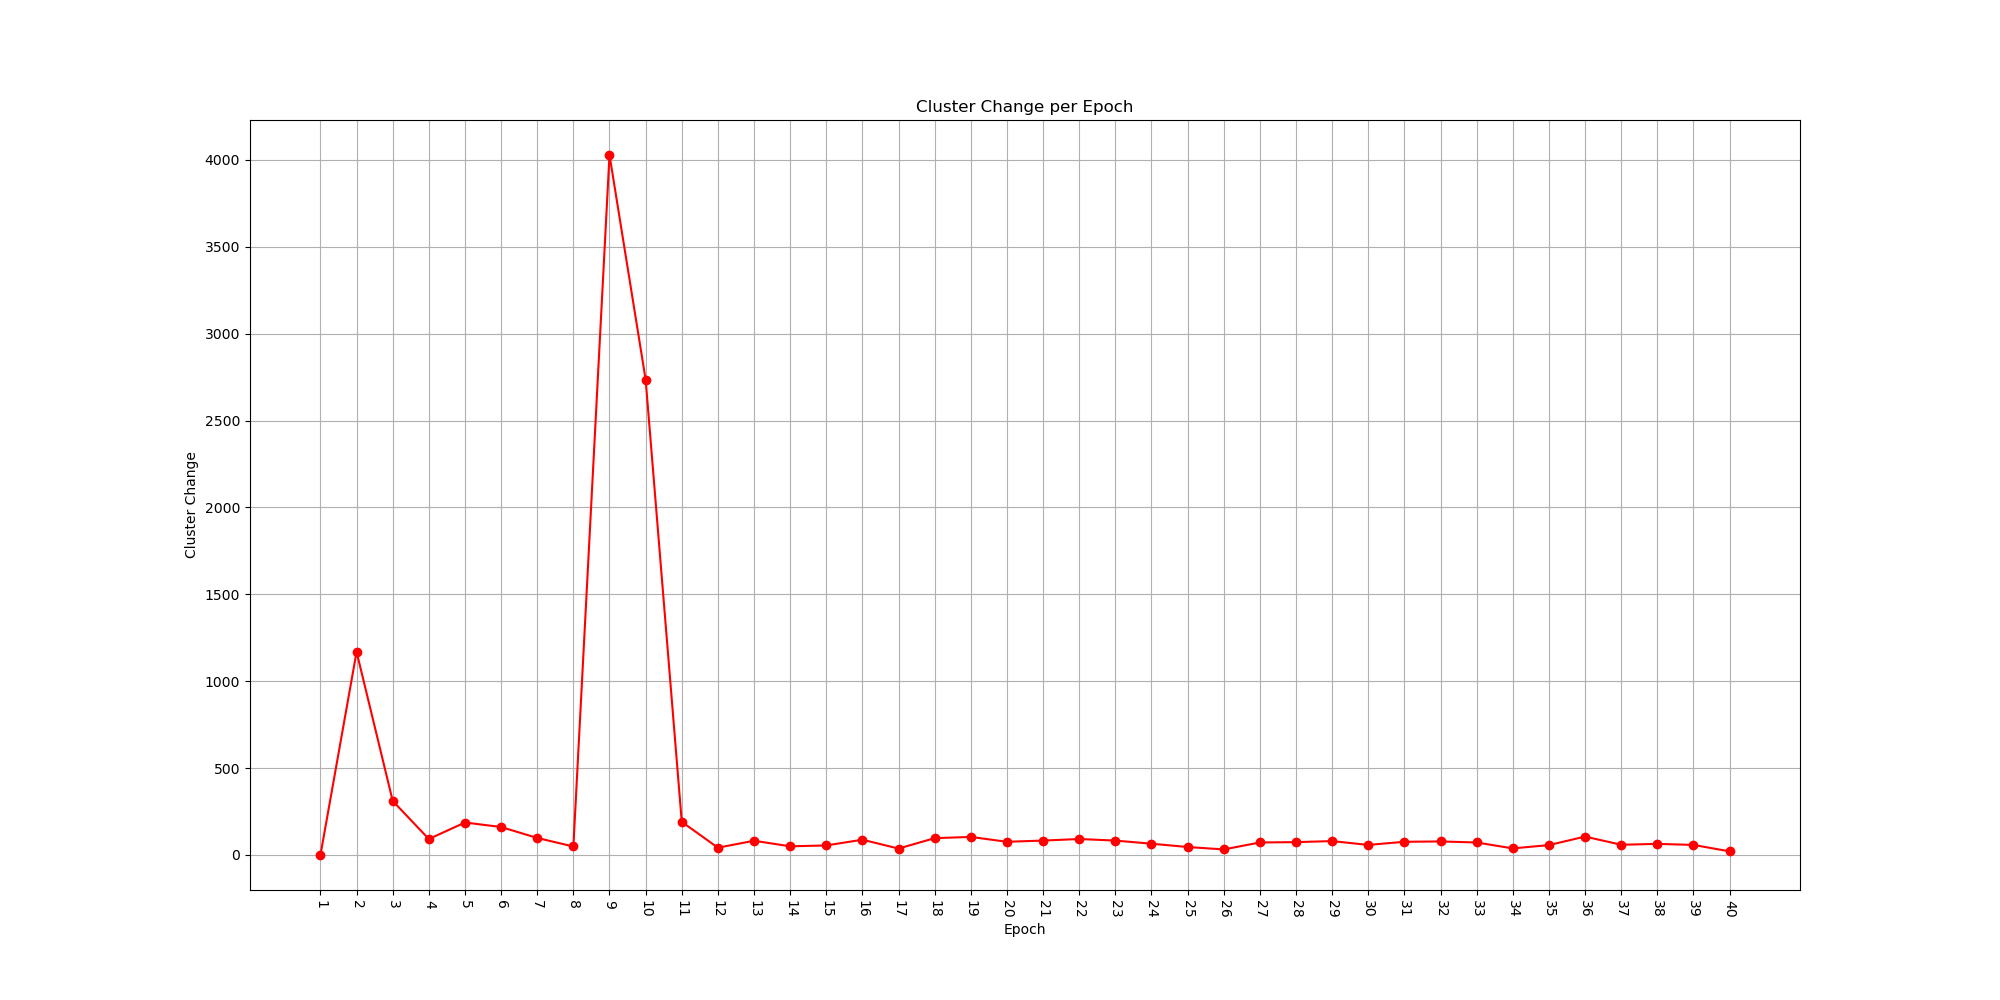

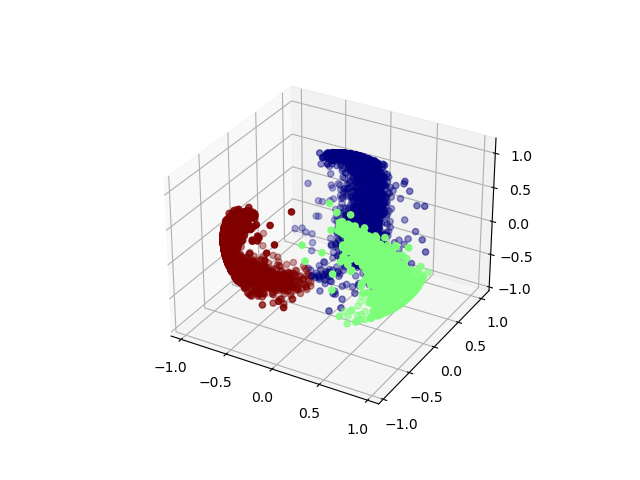

In [31]:
cluster_labels = deepcluster.train_deepcluster(
    peaks_dataset, peaks_dataloader,
    deepcluster_model, 
    gmm, 
    num_classes,
    deepcluster_kwargs
)

## 5. Compare DeepSpikeSort output

In [43]:
peak_times = deepcluster.get_peak_times(peaks_dataset.image_paths)

In [46]:
# Create custom NumpySorting object
sorting_dss = deepcluster.create_numpy_sorting(peak_times, cluster_labels, 30000)
sorting_dss

NumpySorting: 3 units - 1 segments - 30.0kHz

In [35]:
sorting_selected = sorting_nwb.select_units(unit_ids=selected_units)
sorting_selected

UnitsSelectionSorting: 3 units - 1 segments - 30.0kHz

In [36]:
# Run the comparison
cmp_nwb_dss = si.compare_two_sorters(
    sorting1=sorting_dss,
    sorting2=sorting_selected,
    sorting1_name='DeepSpikeSort',
    sorting2_name='NWB',
)

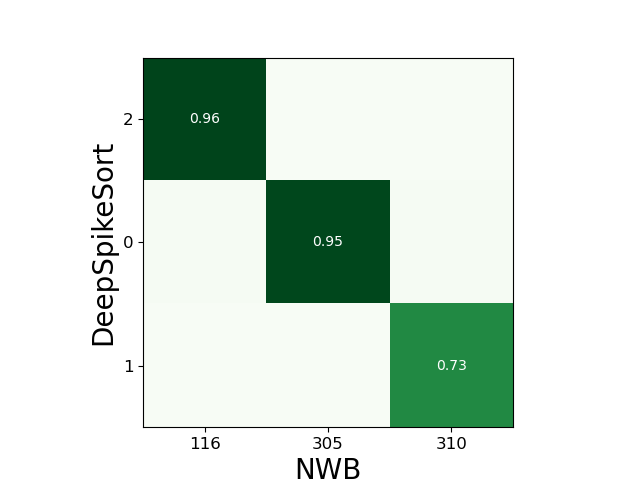

In [37]:
# We can check the agreement matrix to inspect the matching.
si.plot_agreement_matrix(cmp_nwb_dss)

In [38]:
# Some useful internal dataframes help to check the match and count
#  like **match_event_count** or **agreement_scores**
display(cmp_nwb_dss.match_event_count)
display(cmp_nwb_dss.agreement_scores)

,305,116,310
0,3059,55,70
1,1,7,3646
2,4,3274,7


,305,116,310
0,0.946766,0.008382,0.008656
1,0.000147,0.000983,0.726440
2,0.000630,0.959836,0.000852


In [39]:
# In order to check which units were matched, the `get_matching` method can be used.
# If units are not matched they are listed as -1.
dss_to_nwb, _ = cmp_nwb_dss.get_matching()
display(dss_to_nwb)

0    305.0
1    310.0
2    116.0
dtype: float64